# Data Preparation


### Importing Packages

Here, we import the necessary Packages

In [1]:
import numpy as np
import nibabel as nib                                                     

from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate # Using Basic Image agumentation techniques will receive Fake Images 
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
%matplotlib inline
import seaborn as sns

import os
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
import cv2

In [2]:
import segmentation_models as sm
import tensorflow as tf
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset
from keras.models import load_model
from tensorflow.keras import utils as np_utils
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

Segmentation Models: using `keras` framework.


About Data:

All multimodal scans (Images) are available as NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

## Import Dataset path

(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)
(240, 256, 512)


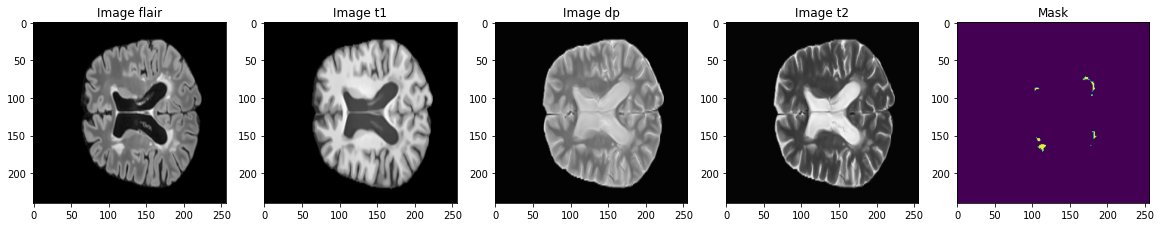

In [3]:
TRAIN_DATASET_PATH = 'D:/Projects/39111/Second_update/MSSEG2016_TrainingData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T1_preprocessed.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_T2_preprocessed.nii').get_fdata()
test_image_dp=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_DP_preprocessed.nii').get_fdata()
test_image_Brain_Mask=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii').get_fdata()
    

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w =280
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_dp[:,:,test_image_dp.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image dp')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_image_Brain_Mask[:,:,test_image_Brain_Mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

print(test_image_flair.shape)
print(test_image_t1.shape)
print(test_image_t2.shape)
print(test_image_dp.shape)
print(test_image_Brain_Mask.shape)

In [4]:
SEGMENT_CLASSES = {
    0 : 'NOT_MS',
    1 : 'MS' }


VOLUME_SLICES = 450 
VOLUME_START_AT =280

total count: 3943435


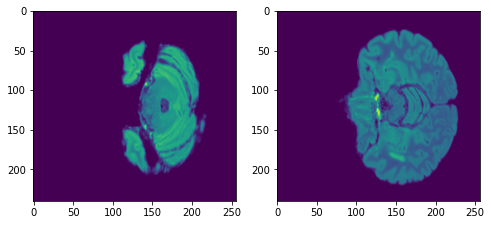

In [5]:
VOLUME_START_AT=260
VOLUME_SLICES=250

def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 10))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

### Show whole nifti data -> print each slice from 3d data

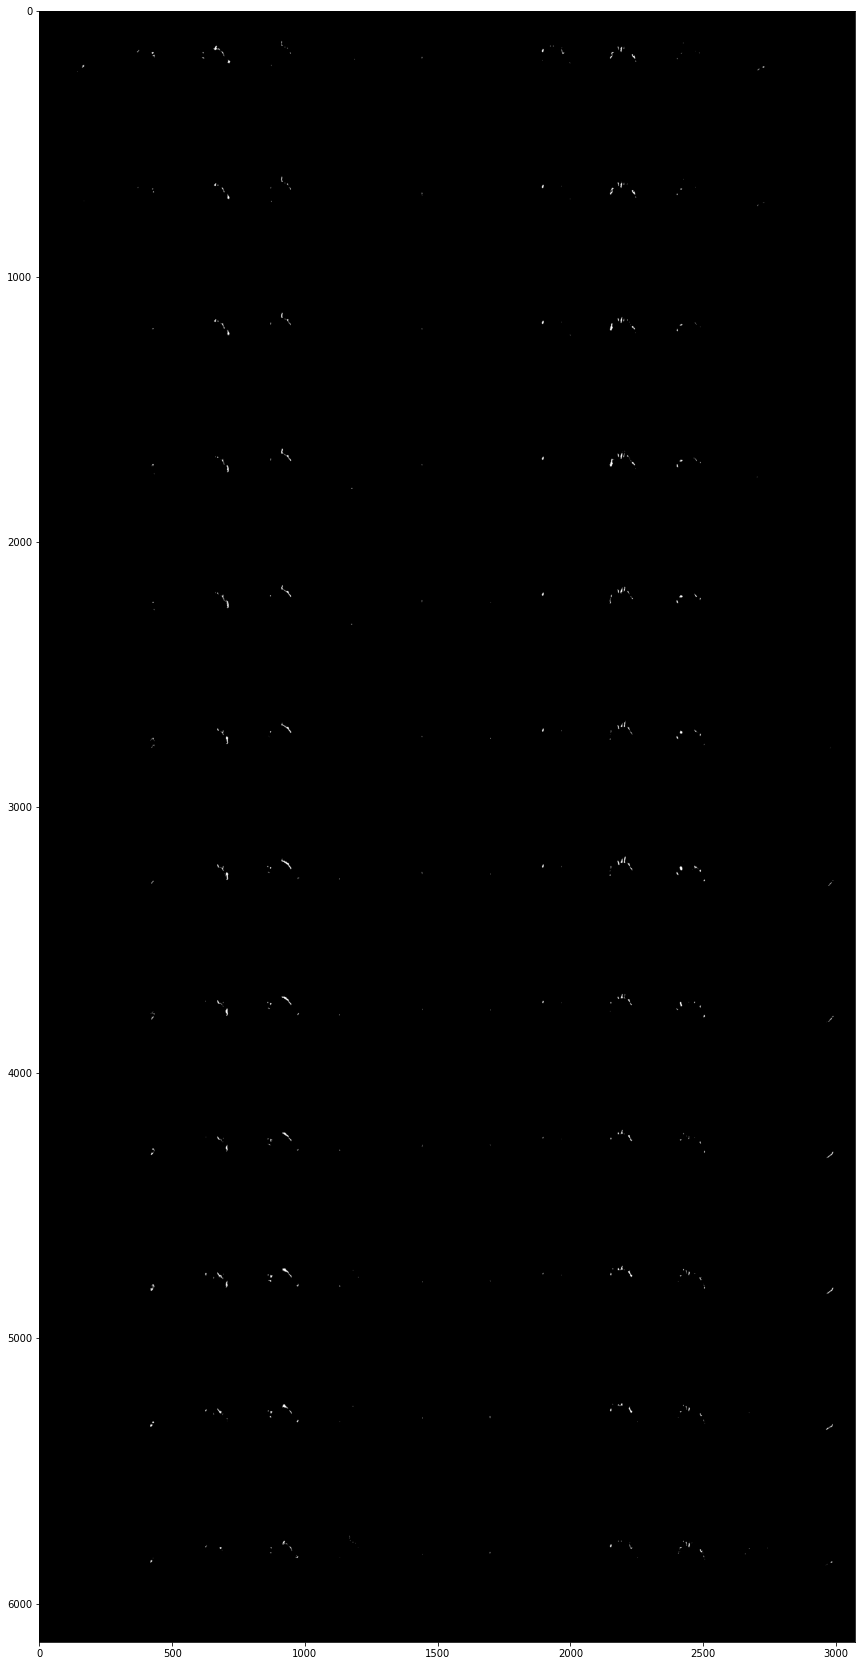

In [6]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,30))
ax1.imshow(rotate(montage(test_image_Brain_Mask[50:-50,:,:]), 90, resize=True), cmap ='gray')

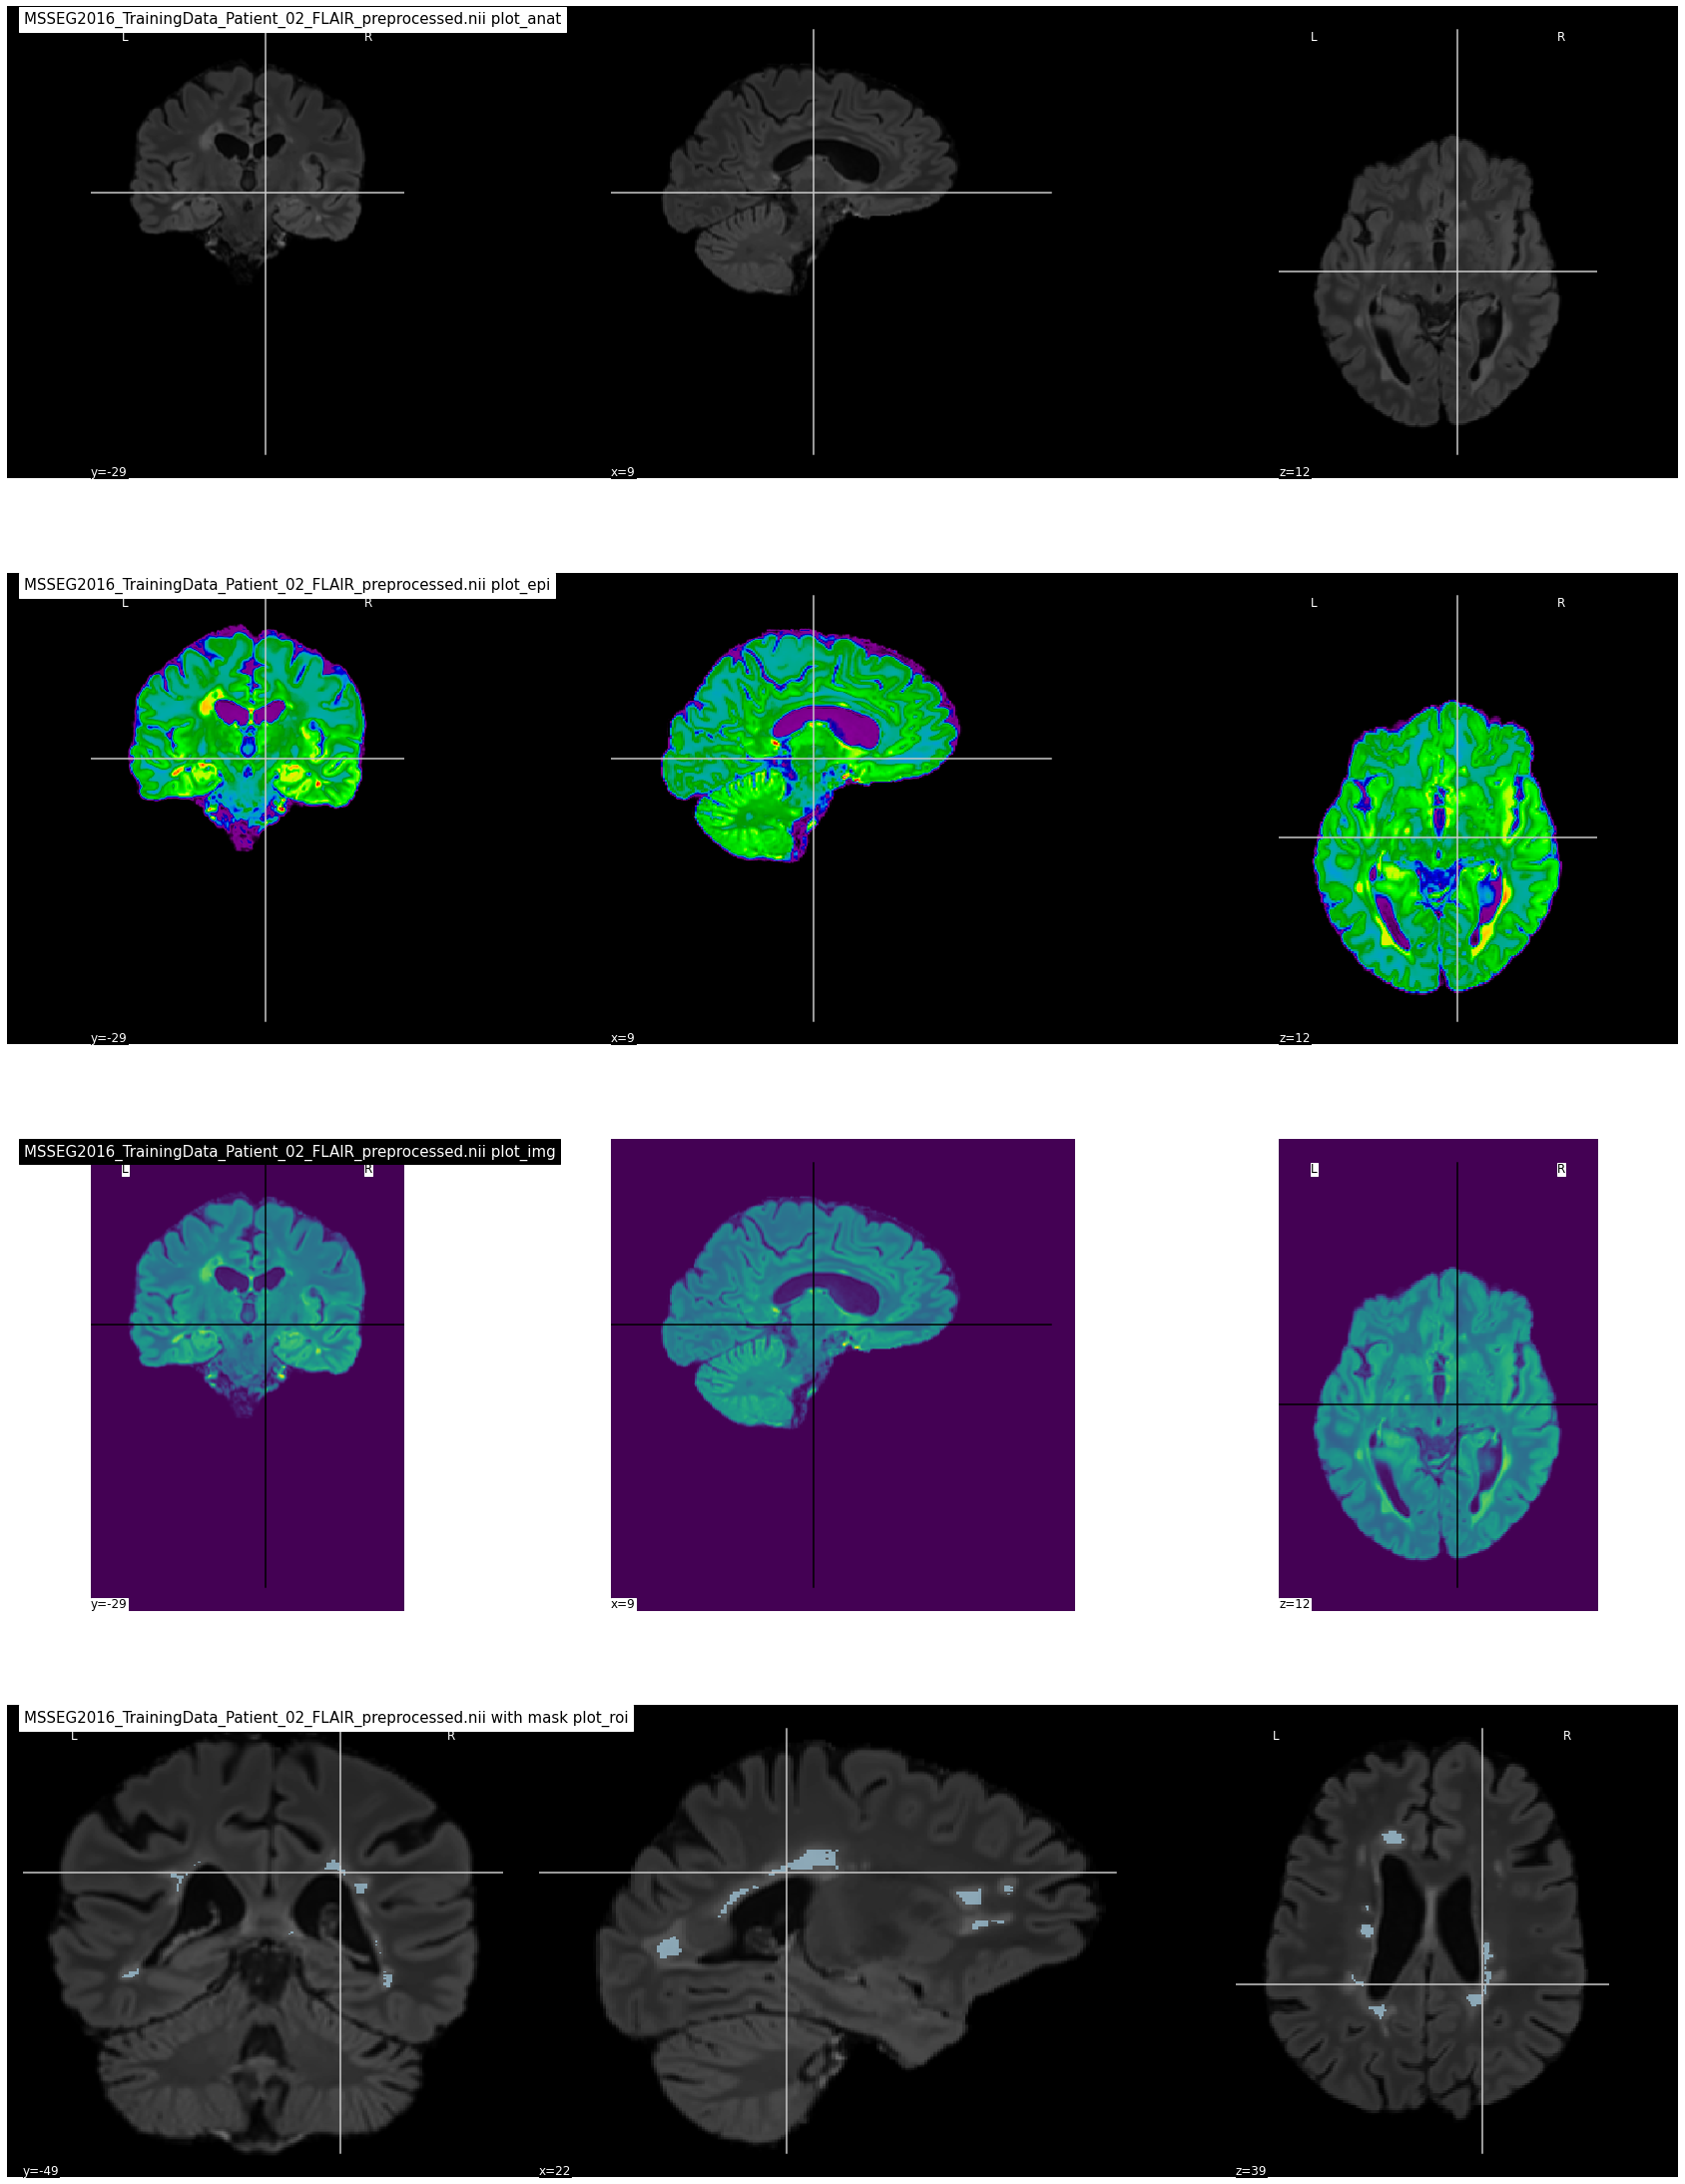

In [7]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'MSSEG2016_TrainingData_Patient_02/MSSEG2016_TrainingData_Patient_02_Consensus.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='MSSEG2016_TrainingData_Patient_02_FLAIR_preprocessed.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

Dice Loss. The Dice coefficient is widely used metric in computer vision community to calculate the similarity between two images

Dice Loss is widely used in medical image segmentation tasks to address the data imbalance problem. However, it only addresses the imbalance problem between foreground and background yet overlooks another imbalance between easy and hard examples that also severely affects the training process of a learning model.

Loss function :

Dice coefficient , which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

The Dice coefficient is very similar to the IoU. They are positively correlated, meaning if one says model A is better than model B at segmenting an image, then the other will say the same. Like the IoU, they both range from 0 to 1, with 1 signifying the greatest similarity between predicted and truth.

In [6]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 2
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num

    return total_loss

def dice_coef_MS(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

Loading all data into memory is not a good idea since the data are too big to fit in. So we will create dataGenerators - load data on the fly.

Prepare image paths to feed DataGenerator function

In [8]:
IMG_SIZE=128

In [9]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size =1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
                
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 256))
        
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 2))
        
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_FLAIR_preprocessed.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_DP_preprocessed.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_Consensus.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
            
        # Generate masks
        y[y==0] = 0;
        
        mask = tf.one_hot(y, 2);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
    

        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


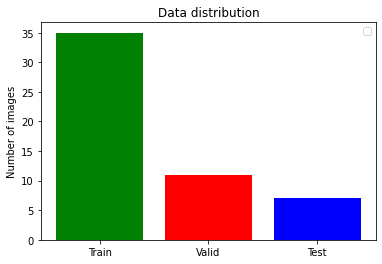

In [10]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

## Existing Model # 1

### UNET Architechture

In [20]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(256,1,2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv71 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)
    conv7 = concatenate([conv7,conv71], axis = 3)
    
    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(128,1,2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv81 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv81)
    conv8 = concatenate([conv8,conv81], axis = 3)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(64,1,2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv91)
    conv9 = concatenate([conv9,conv91], axis = 3)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(Conv2DTranspose(32,1,2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    conv = concatenate([conv,conv1], axis = 3)
    
    conv10 = Conv2D(2, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef,dice_coef_MS, precision, sensitivity, specificity] )

In [21]:
csv_logger = CSVLogger('UNET_.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        
    ]

In [22]:
%%time

history =  model.fit (  training_generator,
                        callbacks= callbacks,
                        epochs=2,
                        batch_size=1120,
                        validation_data = valid_generator )

model.save("UNET_.h5")

Epoch 1/2
35/35 [==============================] - 2882s 82s/step - loss: 12974.7705 - accuracy: 0.9983 - mean_io_u_2: 0.5342 - dice_coef: 0.4897 - dice_coef_MS: 0.0022 - precision: 0.9979 - sensitivity: 0.9920 - specificity: 0.9920 - val_loss: 0.0097 - val_accuracy: 0.9994 - val_mean_io_u_2: 0.2501 - val_dice_coef: 0.4991 - val_dice_coef_MS: 0.0154 - val_precision: 0.9993 - val_sensitivity: 0.9994 - val_specificity: 0.9994 - lr: 0.0050
Epoch 2/2
35/35 [==============================] - 2705s 77s/step - loss: 0.0084 - accuracy: 0.9992 - mean_io_u_2: 0.3351 - dice_coef: 0.5013 - dice_coef_MS: 0.0161 - precision: 0.9990 - sensitivity: 0.9992 - specificity: 0.9992 - val_loss: 0.0062 - val_accuracy: 0.9994 - val_mean_io_u_2: 0.6731 - val_dice_coef: 0.5004 - val_dice_coef_MS: 4.3465e-04 - val_precision: 0.9993 - val_sensitivity: 0.9994 - val_specificity: 0.9994 - lr: 0.0050
Wall time: 1h 33min 11s


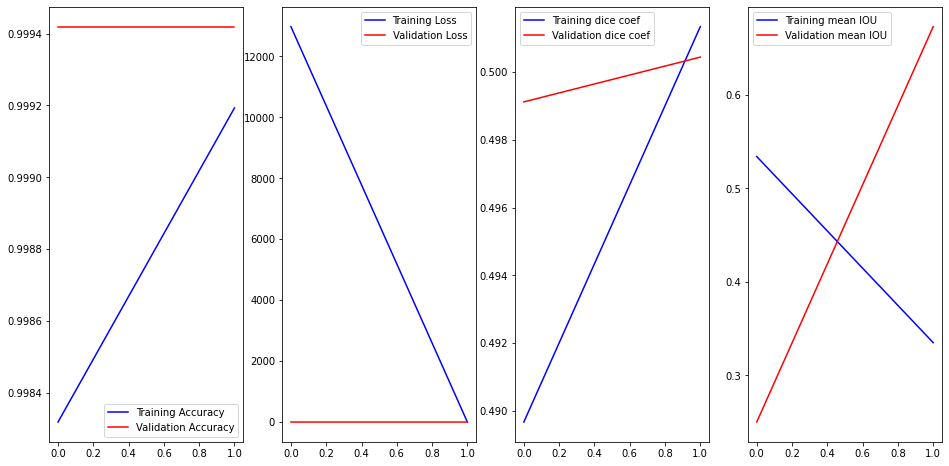

In [30]:
hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u_2'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u_2'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

## Existing Model # 2

### WITH RESNET

In [23]:
BACKBONE = 'resnet50'

preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 2 
activation = 'softmax'

#create model
model_resnet = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True, input_shape = (128,128,2))


# compile keras model with defined optimozer, loss and metrics
model_resnet.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, specificity] )

model_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 128, 128, 2)  6           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 2)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 64, 64, 64)   6272        ['zero_padding2d[0][0]']   

 stage1_unit3_bn1 (BatchNormali  (None, 32, 32, 256)  1024       ['add_1[0][0]']                  
 zation)                                                                                          
                                                                                                  
 stage1_unit3_relu1 (Activation  (None, 32, 32, 256)  0          ['stage1_unit3_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage1_unit3_conv1 (Conv2D)    (None, 32, 32, 64)   16384       ['stage1_unit3_relu1[0][0]']     
                                                                                                  
 stage1_unit3_bn2 (BatchNormali  (None, 32, 32, 64)  256         ['stage1_unit3_conv1[0][0]']     
 zation)                                                                                          
          

                                                                                                  
 stage2_unit2_relu3 (Activation  (None, 16, 16, 128)  0          ['stage2_unit2_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage2_unit2_conv3 (Conv2D)    (None, 16, 16, 512)  65536       ['stage2_unit2_relu3[0][0]']     
                                                                                                  
 add_4 (Add)                    (None, 16, 16, 512)  0           ['stage2_unit2_conv3[0][0]',     
                                                                  'add_3[0][0]']                  
                                                                                                  
 stage2_unit3_bn1 (BatchNormali  (None, 16, 16, 512)  2048       ['add_4[0][0]']                  
 zation)  

 zero_padding2d_9 (ZeroPadding2  (None, 18, 18, 256)  0          ['stage3_unit1_relu2[0][0]']     
 D)                                                                                               
                                                                                                  
 stage3_unit1_conv2 (Conv2D)    (None, 8, 8, 256)    589824      ['zero_padding2d_9[0][0]']       
                                                                                                  
 stage3_unit1_bn3 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit1_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit1_relu3 (Activation  (None, 8, 8, 256)   0           ['stage3_unit1_bn3[0][0]']       
 )                                                                                                
          

                                                                                                  
 stage3_unit4_conv1 (Conv2D)    (None, 8, 8, 256)    262144      ['stage3_unit4_relu1[0][0]']     
                                                                                                  
 stage3_unit4_bn2 (BatchNormali  (None, 8, 8, 256)   1024        ['stage3_unit4_conv1[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage3_unit4_relu2 (Activation  (None, 8, 8, 256)   0           ['stage3_unit4_bn2[0][0]']       
 )                                                                                                
                                                                                                  
 zero_padding2d_12 (ZeroPadding  (None, 10, 10, 256)  0          ['stage3_unit4_relu2[0][0]']     
 2D)      

                                                                  'add_11[0][0]']                 
                                                                                                  
 stage4_unit1_bn1 (BatchNormali  (None, 8, 8, 1024)  4096        ['add_12[0][0]']                 
 zation)                                                                                          
                                                                                                  
 stage4_unit1_relu1 (Activation  (None, 8, 8, 1024)  0           ['stage4_unit1_bn1[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit1_conv1 (Conv2D)    (None, 8, 8, 512)    524288      ['stage4_unit1_relu1[0][0]']     
                                                                                                  
 stage4_un

 stage4_unit3_bn3 (BatchNormali  (None, 4, 4, 512)   2048        ['stage4_unit3_conv2[0][0]']     
 zation)                                                                                          
                                                                                                  
 stage4_unit3_relu3 (Activation  (None, 4, 4, 512)   0           ['stage4_unit3_bn3[0][0]']       
 )                                                                                                
                                                                                                  
 stage4_unit3_conv3 (Conv2D)    (None, 4, 4, 2048)   1048576     ['stage4_unit3_relu3[0][0]']     
                                                                                                  
 add_15 (Add)                   (None, 4, 4, 2048)   0           ['stage4_unit3_conv3[0][0]',     
                                                                  'add_14[0][0]']                 
          

                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 64, 64)  0           ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_stage3_concat (Concate  (None, 64, 64, 128)  0          ['decoder_stage3_upsampling[0][0]
 nate)                                                           ',                               
                                                                  'relu0[0][0]']                  
                                                                                                  
 decoder_stage3a_conv (Conv2D)  (None, 64, 64, 32)   36864       ['decoder_stage3_concat[0][0]']  
                                                                                                  
 decoder_s

In [24]:
csv_logger = CSVLogger('RESNET_.log', separator=',', append=False)


callbacks = [
#     keras.callbacks.EarlyStopping(monitor='loss', min_delta=0,
#                               patience=2, verbose=1, mode='auto'),
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1)
#  keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.m5',
#                             verbose=1, save_best_only=True, save_weights_only = True)
        
    ]

In [25]:
%%time

history1 =  model_resnet.fit (  training_generator,
                        epochs=2,
                        validation_data = valid_generator )
 

model_resnet.save("RESNET_.h5")

Epoch 1/2
35/35 [==============================] - 2657s 77s/step - loss: 0.0549 - accuracy: 0.9852 - mean_io_u_3: 0.2502 - dice_coef: 0.4904 - precision: 0.9850 - sensitivity: 0.9851 - specificity: 0.9851 - val_loss: 0.9782 - val_accuracy: 0.9994 - val_mean_io_u_3: 0.6780 - val_dice_coef: 0.4979 - val_precision: 0.9993 - val_sensitivity: 0.9994 - val_specificity: 0.9994
Epoch 2/2
35/35 [==============================] - 1605s 46s/step - loss: 0.0056 - accuracy: 0.9992 - mean_io_u_3: 0.2502 - dice_coef: 0.5031 - precision: 0.9990 - sensitivity: 0.9992 - specificity: 0.9992 - val_loss: 0.0076 - val_accuracy: 0.9994 - val_mean_io_u_3: 0.2501 - val_dice_coef: 0.5010 - val_precision: 0.9993 - val_sensitivity: 0.9994 - val_specificity: 0.9994
Wall time: 1h 11min 6s


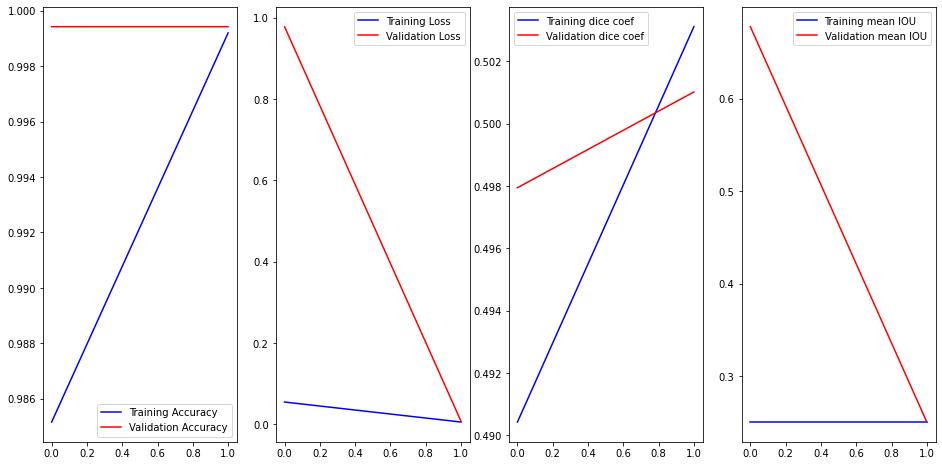

In [29]:
hist1=history1.history

acc=hist1['accuracy']
val_acc=hist1['val_accuracy']

epoch=range(len(acc))

loss=hist1['loss']
val_loss=hist1['val_loss']

train_dice=hist1['dice_coef']
val_dice=hist1['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist1['mean_io_u_3'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist1['val_mean_io_u_3'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

## Existing Model # 3

### With inceptionv3_unet

In [33]:
def inceptionv3_unet():
    
    BACKBONE = 'inceptionv3'
    
    preprocess_input = sm.get_preprocessing(BACKBONE)
    
    n_classes = 2
    
    activation = 'softmax'
    
    model = sm.Unet(BACKBONE, classes=n_classes, input_shape=(IMG_SIZE, IMG_SIZE, 2), activation=activation, encoder_weights=None, encoder_freeze=True)
    
    return model



In [34]:
model_inceptionv3 = inceptionv3_unet()

model_inceptionv3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=2), dice_coef, precision, sensitivity, specificity] )

model_inceptionv3.summary()

C:\Anaconda3\lib\site-packages\keras_applications\imagenet_utils.py:276: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 2 input channels.
  warnings.warn(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_105 (Conv2D)            (None, 64, 64, 32)   576         ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  96          ['conv2d_105[0][0]']             
 alization)                                                                                       
                                                                                            

 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_115[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_116[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activatio

 activation_22 (Activation)     (None, 16, 16, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_125 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_128 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_125[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_128[0][0]']             
 ormalizat

 mixed3 (Concatenate)           (None, 8, 8, 768)    0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_14[0][0]']       
                                                                                                  
 conv2d_139 (Conv2D)            (None, 8, 8, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 8, 8, 128)   384         ['conv2d_139[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_34[0][0]'] 
          

                                                                                                  
 batch_normalization_44 (BatchN  (None, 8, 8, 160)   480         ['conv2d_149[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 8, 8, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_150 (Conv2D)            (None, 8, 8, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 8, 8, 160)   480         ['conv2d_150[0][0]']             
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_160 (Conv2D)            (None, 8, 8, 160)    179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 8, 8, 160)   480         ['conv2d_160[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 8, 8, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_156 (Conv2D)            (None, 8, 8, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_16

                                                                                                  
 activation_65 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_166 (Conv2D)            (None, 8, 8, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_171 (Conv2D)            (None, 8, 8, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 8, 8, 192)   576         ['conv2d_166[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 conv2d_179 (Conv2D)            (None, 8, 8, 192)    258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 8, 8, 192)   576         ['conv2d_175[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 8, 8, 192)   576         ['conv2d_179[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 8, 8, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 activation_78 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 4, 4, 192)   576         ['conv2d_189[0][0]']             
 ormalizat

                                                                                                  
 activation_92 (Activation)     (None, 4, 4, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 4, 4, 192)   576         ['conv2d_198[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 4, 4, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 4, 4, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
          

                                                                                                  
 decoder_stage2b_bn (BatchNorma  (None, 32, 32, 64)  256         ['decoder_stage2b_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage2b_relu (Activati  (None, 32, 32, 64)  0           ['decoder_stage2b_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage3_upsampling (UpS  (None, 64, 64, 64)  0           ['decoder_stage2b_relu[0][0]']   
 ampling2D)                                                                                       
                                                                                                  
 decoder_s

In [35]:
%%time

history2 =  model_inceptionv3.fit (  training_generator,
                        epochs=2,
                        validation_data = valid_generator )
 

model_inceptionv3.save("INCEPTIONV3_.h5")

Epoch 1/2
35/35 [==============================] - 1993s 57s/step - loss: 0.1112 - accuracy: 0.9479 - mean_io_u_4: 0.2501 - dice_coef: 0.4765 - precision: 0.9477 - sensitivity: 0.9478 - specificity: 0.9478 - val_loss: 0.0287 - val_accuracy: 0.9995 - val_mean_io_u_4: 0.3243 - val_dice_coef: 0.4952 - val_precision: 0.9994 - val_sensitivity: 0.9995 - val_specificity: 0.9995
Epoch 2/2
35/35 [==============================] - 2040s 58s/step - loss: 0.0047 - accuracy: 0.9994 - mean_io_u_4: 0.2501 - dice_coef: 0.5012 - precision: 0.9993 - sensitivity: 0.9994 - specificity: 0.9994 - val_loss: 0.0137 - val_accuracy: 0.9995 - val_mean_io_u_4: 0.2501 - val_dice_coef: 0.4975 - val_precision: 0.9994 - val_sensitivity: 0.9995 - val_specificity: 0.9995
Wall time: 1h 7min 17s


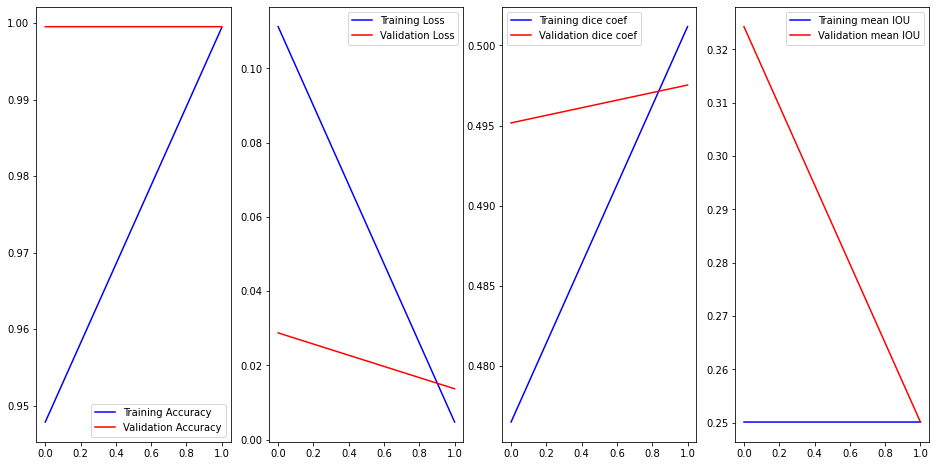

In [36]:
hist1=history2.history

acc=hist1['accuracy']
val_acc=hist1['val_accuracy']

epoch=range(len(acc))

loss=hist1['loss']
val_loss=hist1['val_loss']

train_dice=hist1['dice_coef']
val_dice=hist1['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist1['mean_io_u_4'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist1['val_mean_io_u_4'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()